In [1]:
import pandas as pd
import torch
import numpy as np
from src.utils.finger import encode
from src.utils.modelinit import initialize_model
from scipy.spatial.distance import jaccard, euclidean

In [2]:
# load validation set for klek
df_klek = pd.read_parquet('data/train_data/big_dataset_std.parquet').sample(10000)

# load validation set for ECFP
df_ECFP = pd.read_parquet('data/train_data/big_dataset_ECFP.parquet').sample(10000)

In [3]:
def unpack(bs):
    bs = str(bs)
    bs = bs.lstrip("b'[").rstrip("']").split(',')
    bs = [int(x) for x in bs]
    return bs

def repack(bs, lg):
    vec = np.zeros(lg)
    vec[bs] = 1
    return vec

In [4]:
df_klek['fps'] = df_klek['fps'].apply(unpack)
df_ECFP['fps'] = df_ECFP['fps'].apply(unpack)
klek_original = df_klek['fps'].apply(repack, lg=4860)
ECFP_original = df_ECFP['fps'].apply(repack, lg=2048)
klek_original = np.array([x for x in klek_original.to_numpy()])
ECFP_original = np.array([x for x in ECFP_original.to_numpy()])

In [5]:
# path to klek model weights
klek_path = 'models/GRUv3_klek_sonic/epoch_200.pt'
klek_config_path = 'models/GRUv3_klek_sonic/hyperparameters.ini'

# path to ECFP model weights
ECFP_path = 'models/GRUv3_ECFP_tola/epoch_150.pt'
ECFP_config_path = 'models/GRUv3_ECFP_tola/hyperparameters.ini'

In [6]:
# initialize models and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

klek_model = initialize_model(klek_config_path, dropout=False, device=device)
klek_model.load_state_dict(torch.load(klek_path, map_location=device))

ECFP_model = initialize_model(ECFP_config_path, dropout=False, device=device)
ECFP_model.load_state_dict(torch.load(ECFP_path, map_location=device))

print(device)

cuda


In [7]:
klek_encoded, _ = encode(df_klek, klek_model, device)
ECFP_encoded, _ = encode(df_ECFP, ECFP_model, device)

print(klek_encoded.shape) # (10000, 32)
print(ECFP_encoded.shape) # (10000, 32)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

(10000, 32)
(10000, 32)


In [8]:
klek_norm = np.linalg.norm(klek_encoded, axis=1)
ECFP_norm = np.linalg.norm(ECFP_encoded, axis=1)

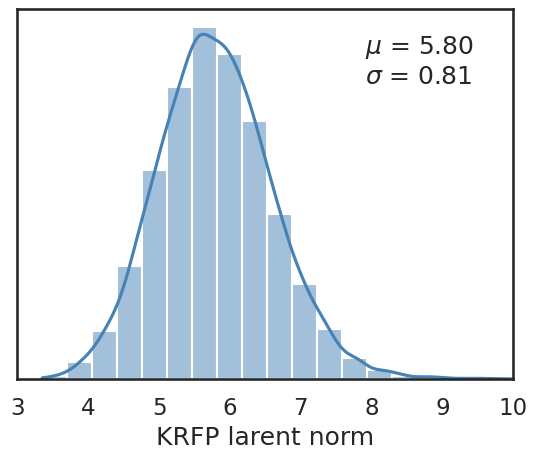

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('talk')
fig = sns.histplot(klek_norm, bins=20, color='steelblue', label='Klek', kde=True)
mean_klek = np.mean(klek_norm)
std_klek = np.std(klek_norm)
fig.text(0.7, 0.8, f'$\mu$ = {mean_klek:.2f}\n$\sigma$ = {std_klek:.2f}', transform=plt.gca().transAxes)
plt.ylabel('')
plt.yticks([])
plt.xticks(range(3,11))
plt.xlim(3,10)
plt.xlabel('KRFP larent norm')
plt.savefig('plots/klek_norm.pdf', format='pdf',  dpi=300, bbox_inches='tight')

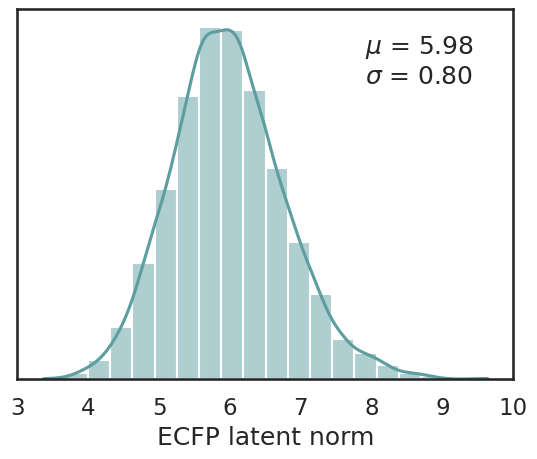

In [79]:
sns.set_style('white')
sns.set_context('talk')
fig = sns.histplot(ECFP_norm, bins=20, color='cadetblue', label='ECFP', kde=True)
mean_ECFP = np.mean(ECFP_norm)
std_ECFP = np.std(ECFP_norm)
fig.text(0.7, 0.8, f'$\mu$ = {mean_ECFP:.2f}\n$\sigma$ = {std_ECFP:.2f}', transform=plt.gca().transAxes)
plt.ylabel('')
plt.yticks([])
plt.xlabel('ECFP latent norm')
plt.xticks(range(3,11))
plt.xlim(3,10)
plt.savefig('plots/ECFP_norm.pdf', format='pdf',  dpi=300, bbox_inches='tight')